In [1]:
import pandas as pd
import numpy as np
import os

In [15]:
list_csv = os.listdir('../data/')
list_csv=sorted(list_csv)
idx = 0
data_length=500
data=pd.DataFrame(columns=['Num','R','S','T','label'])
for path in list_csv:
    data_tmp = pd.DataFrame(columns=['Num','R','S','T','label'])
    df = pd.read_csv('../data/' + path)
    data_tmp[['R','S','T']] = df[['x','y','z']]
    data_tmp['Num'] = idx
    if 'normal' in path or '정상' in path:
        data_tmp['label'] = 0
    else:
        data_tmp['label'] = 1
    if idx == 0:
        data[['Num','R','S','T','label']]=data_tmp[['Num','R','S','T','label']]
    else:
        data = pd.concat([data, data_tmp])
    idx = idx + 1
data.reset_index(drop=True, inplace=True)
data['R']=(data['R']-data['R'].mean(axis=0))/data['R'].std(axis=0)
data['S']=(data['S']-data['S'].mean(axis=0))/data['S'].std(axis=0)
data['T']=(data['T']-data['T'].mean(axis=0))/data['T'].std(axis=0)
R=np.array(data['R']).reshape(int(len(data['R'])/data_length),data_length)
S=np.array(data['S']).reshape(int(len(data['S'])/data_length),data_length)
T=np.array(data['T']).reshape(int(len(data['T'])/data_length),data_length)
label=np.array(data['label']).reshape(int(len(data['label'])/data_length),data_length).sum(axis=1)/data_length
data_array=np.stack([R,S,T],axis=2)

In [16]:
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, Activation, Dropout, Reshape
from tensorflow.keras import Model
from tensorflow.keras import initializers
from tensorflow import keras
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras import optimizers

In [ ]:
model_inputs = keras.Input(shape=(data_length,3))
initializer = initializers.RandomNormal(mean=0., stddev=1.)
encode_x = Conv1D(16, 5, padding='causal', kernel_initializer='he_uniform',
               bias_initializer=initializer)(model_inputs)
encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
encode_x = Activation(activation='relu')(encode_x)
encode_x = Dropout(0.2)(encode_x)

encode_x = Conv1D(32, 5, padding='causal', dilation_rate=2, kernel_initializer='he_uniform',
               bias_initializer=initializer)(encode_x)
encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
encode_x = Activation(activation='relu')(encode_x)
encode_x = Dropout(0.2)(encode_x)

encode_x = Conv1D(64, 5, padding='causal', dilation_rate=4, kernel_initializer='he_uniform',
               bias_initializer=initializer)(encode_x)
encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
encode_x = Activation(activation='relu')(encode_x)
encode_x = Dropout(0.2)(encode_x)

encode_x = Conv1D(128, 5, padding='causal', dilation_rate=8, kernel_initializer='he_uniform',
               bias_initializer=initializer)(encode_x)
encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
encode_x = Activation(activation='relu')(encode_x)
encode_x = Dropout(0.2)(encode_x)

encode_x = Conv1D(256, 5, padding='causal', dilation_rate=16, kernel_initializer='he_uniform',
               bias_initializer=initializer)(encode_x)
encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
encode_x = Activation(activation='relu')(encode_x)
encode_x = Dropout(0.2)(encode_x)

encode_x = Conv1D(1, 1, kernel_initializer='he_uniform',
               bias_initializer=initializer)(encode_x)
encode_x = Flatten()(encode_x)
encode_x = Dense(50, kernel_initializer='he_uniform',
              bias_initializer=initializer)(encode_x)
encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
encode_x = Activation(activation='relu')(encode_x)

encoder = Dense(2, use_bias=True)(encode_x)

decoder_x = Dense(50)(encoder)
decoder_x = Dense(data_length)(decoder_x)
decoder_x = Reshape((data_length,1))(decoder_x)
decoder_x = Conv1D(256, 1, kernel_initializer='he_uniform',
               bias_initializer=initializer)(decoder_x)

decoder_x = Conv1D(128, 5, padding='causal', dilation_rate=16, kernel_initializer='he_uniform',
               bias_initializer=initializer)(decoder_x)
decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
decoder_x = Activation(activation='relu')(decoder_x)
decoder_x = Dropout(0.2)(decoder_x)

decoder_x = Conv1D(64, 5, padding='causal', dilation_rate=8, kernel_initializer='he_uniform',
               bias_initializer=initializer)(decoder_x)
decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
decoder_x = Activation(activation='relu')(decoder_x)
decoder_x = Dropout(0.2)(decoder_x)

decoder_x = Conv1D(32, 5, padding='causal', dilation_rate=4, kernel_initializer='he_uniform',
               bias_initializer=initializer)(decoder_x)
decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
decoder_x = Activation(activation='relu')(decoder_x)
decoder_x = Dropout(0.2)(decoder_x)

decoder_x = Conv1D(16, 5, padding='causal', dilation_rate=2, kernel_initializer='he_uniform',
               bias_initializer=initializer)(decoder_x)
decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
decoder_x = Activation(activation='relu')(decoder_x)
decoder_x = Dropout(0.2)(decoder_x)

decoder_x = Conv1D(3, 5, padding='causal', dilation_rate=1, kernel_initializer='he_uniform',
               bias_initializer=initializer)(decoder_x)
decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
decoder_x = Activation(activation='relu')(decoder_x)
decoder = Dropout(0.2)(decoder_x)

autoencoder = Model(model_inputs, decoder)
Encoder= Model(model_inputs,encoder)
autoencoder.summary()

In [17]:
# model_inputs = keras.Input(shape=(data_length,3))
# initializer = initializers.RandomNormal(mean=0., stddev=1.)
# encode_x = Conv1D(16, 5, padding='causal', kernel_initializer='he_uniform',
#                bias_initializer=initializer)(model_inputs)
# encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
# encode_x = Activation(activation='relu')(encode_x)
# encode_x = Dropout(0.2)(encode_x)

# encode_x = Conv1D(32, 5, padding='causal', dilation_rate=2, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(encode_x)
# encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
# encode_x = Activation(activation='relu')(encode_x)
# encode_x = Dropout(0.2)(encode_x)

# encode_x = Conv1D(64, 5, padding='causal', dilation_rate=4, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(encode_x)
# encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
# encode_x = Activation(activation='relu')(encode_x)
# encode_x = Dropout(0.2)(encode_x)

# encode_x = Conv1D(128, 5, padding='causal', dilation_rate=8, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(encode_x)
# encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
# encode_x = Activation(activation='relu')(encode_x)
# encode_x = Dropout(0.2)(encode_x)

# encode_x = Conv1D(256, 5, padding='causal', dilation_rate=16, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(encode_x)
# encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
# encode_x = Activation(activation='relu')(encode_x)
# encode_x = Dropout(0.2)(encode_x)

# encode_x = Conv1D(1, 1, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(encode_x)
# encode_x = Flatten()(encode_x)
# encode_x = Dense(50, kernel_initializer='he_uniform',
#               bias_initializer=initializer)(encode_x)
# encode_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(encode_x)
# encode_x = Activation(activation='relu')(encode_x)

# encoder = Dense(2, use_bias=True)(encode_x)

# decoder_x = Dense(50)(encoder)
# decoder_x = Dense(data_length)(decoder_x)
# decoder_x = Reshape((data_length,1))(decoder_x)
# decoder_x = Conv1D(256, 1, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(decoder_x)

# decoder_x = Conv1D(128, 5, padding='causal', dilation_rate=16, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(decoder_x)
# decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
# decoder_x = Activation(activation='relu')(decoder_x)
# decoder_x = Dropout(0.2)(decoder_x)

# decoder_x = Conv1D(64, 5, padding='causal', dilation_rate=8, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(decoder_x)
# decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
# decoder_x = Activation(activation='relu')(decoder_x)
# decoder_x = Dropout(0.2)(decoder_x)

# decoder_x = Conv1D(32, 5, padding='causal', dilation_rate=4, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(decoder_x)
# decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
# decoder_x = Activation(activation='relu')(decoder_x)
# decoder_x = Dropout(0.2)(decoder_x)

# decoder_x = Conv1D(16, 5, padding='causal', dilation_rate=2, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(decoder_x)
# decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
# decoder_x = Activation(activation='relu')(decoder_x)
# decoder_x = Dropout(0.2)(decoder_x)

# decoder_x = Conv1D(3, 5, padding='causal', dilation_rate=1, kernel_initializer='he_uniform',
#                bias_initializer=initializer)(decoder_x)
# decoder_x = BatchNormalization(axis=-1, momentum=0.1, epsilon=0.00001)(decoder_x)
# decoder_x = Activation(activation='relu')(decoder_x)
# decoder = Dropout(0.2)(decoder_x)

# autoencoder = Model(model_inputs, decoder)
# Encoder= Model(model_inputs,encoder)
# autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 500, 3)]          0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 500, 16)           256       
_________________________________________________________________
batch_normalization_33 (Batc (None, 500, 16)           64        
_________________________________________________________________
activation_33 (Activation)   (None, 500, 16)           0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 500, 16)           0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 500, 32)           2592      
_________________________________________________________________
batch_normalization_34 (Batc (None, 500, 32)           128 

In [18]:
shuffle_idx = np.arange(int(len(data['label'])/data_length))
np.random.shuffle(shuffle_idx)
data_array=data_array[shuffle_idx]
label = label[shuffle_idx]

Myadam = tfa.optimizers.extend_with_decoupled_weight_decay(optimizers.Adam)
opt = Myadam(learning_rate=0.001, weight_decay=0.0001)
autoencoder.compile(loss='mse', optimizer=opt, metrics=[tf.keras.metrics.RootMeanSquaredError()])
hist = autoencoder.fit(data_array, data_array, epochs=1000, batch_size=32)  

Epoch 1/1000
3/3 [==============================] - 0s 22ms/step - loss: 1.6285 - root_mean_squared_error: 1.2761
Epoch 2/1000
3/3 [==============================] - 0s 18ms/step - loss: 1.3437 - root_mean_squared_error: 1.1592
Epoch 3/1000
3/3 [==============================] - 0s 19ms/step - loss: 1.2032 - root_mean_squared_error: 1.0969
Epoch 4/1000
3/3 [==============================] - 0s 18ms/step - loss: 1.1389 - root_mean_squared_error: 1.0672
Epoch 5/1000
3/3 [==============================] - 0s 18ms/step - loss: 1.0991 - root_mean_squared_error: 1.0484
Epoch 6/1000
3/3 [==============================] - 0s 19ms/step - loss: 1.0565 - root_mean_squared_error: 1.0278
Epoch 7/1000
3/3 [==============================] - 0s 18ms/step - loss: 0.9938 - root_mean_squared_error: 0.9969
Epoch 8/1000
3/3 [==============================] - 0s 19ms/step - loss: 0.9303 - root_mean_squared_error: 0.9645
Epoch 9/1000
3/3 [==============================] - 0s 21ms/step - loss: 0.8771 - root_m

In [19]:
PCA=Encoder.predict(data_array)
PCA.shape

(80, 2)

<function matplotlib.pyplot.show(close=None, block=None)>

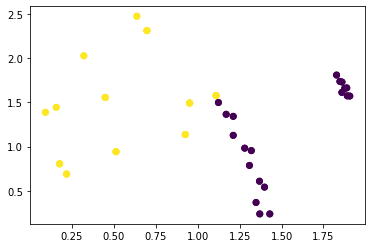

In [20]:
import matplotlib.pyplot as plt
plt.scatter(np.abs(PCA[:,0]),np.abs(PCA[:,1]),c=label)
plt.show

In [32]:
PCA

array([[ 2.4638655 ],
       [ 2.4580903 ],
       [-0.1252547 ],
       [ 1.9014428 ],
       [ 2.4580903 ],
       [ 2.219378  ],
       [ 2.278241  ],
       [ 2.278241  ],
       [ 2.5617359 ],
       [ 0.21255443],
       [-3.979455  ],
       [-0.10259519],
       [ 2.494735  ],
       [ 2.3568678 ],
       [-0.12485769],
       [ 0.21373971],
       [ 2.5617359 ],
       [-4.008001  ],
       [-0.19670516],
       [-0.37071195],
       [-0.1252547 ],
       [-0.08427508],
       [-0.10326292],
       [-3.9641314 ],
       [ 1.9014428 ],
       [-0.08427508],
       [-3.9510684 ],
       [-0.10326292],
       [ 0.1734731 ],
       [-0.08464238],
       [ 0.04205751],
       [-3.966907  ],
       [-0.08508683],
       [ 2.494735  ],
       [ 2.008334  ],
       [ 0.17202243],
       [-0.10259519],
       [-3.9651837 ],
       [-0.30459273],
       [ 0.21255443],
       [-0.37071195],
       [ 2.5980816 ],
       [ 0.1734731 ],
       [-4.001942  ],
       [ 0.04205751],
       [ 0

In [42]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2) # KMeans 객체 생성

model = model.fit(np.stack(PCA,np.zeros(len(PCA)))) 

pred=model.predict(PCA)

ValueError: all input arrays must have the same shape

In [44]:
plt.figure(figsize=(7, 5)) # Figure 창 크기 조절

plt.scatter(PCA[:,0], c=pred, s=100, alpha=0.5)

centers = model.cluster_centers_ # 3개로 Cluster된 edge들의 중앙값

plt.scatter(centers[:,0], centers[:,1], c='red', s=200, alpha=0.5) 
plt.show()

AttributeError: 'KMeans' object has no attribute 'cluster_centers_'

In [18]:
PCA

array([[ 1.8711517 , -1.2969387 ],
       [ 2.1556697 , -0.65215987],
       [ 1.8108464 , -0.4864872 ],
       [ 2.2335296 ,  2.7433724 ],
       [ 1.8974854 , -1.2178642 ],
       [ 1.4868269 , -0.93362397],
       [ 1.865493  ,  3.0834877 ],
       [ 1.4485871 , -1.1862748 ],
       [ 1.8098224 , -0.48614907],
       [-1.5698627 , -2.3145545 ],
       [-1.5213994 , -2.3581083 ],
       [ 1.9983157 ,  2.891337  ],
       [ 0.80271906, -0.42003953],
       [ 1.6186905 ,  3.3487935 ],
       [ 1.9722124 , -0.65457624],
       [ 2.4166555 ,  2.1986716 ],
       [ 2.4166555 ,  2.1986716 ],
       [-1.419135  , -2.358767  ],
       [ 0.80193776, -0.41958624],
       [ 0.91976553, -0.5808325 ],
       [-1.4992865 , -2.3471859 ],
       [ 0.920417  , -0.5810955 ],
       [ 0.80271906, -0.42003953],
       [ 0.83276737, -1.0464327 ],
       [ 1.3882586 ,  3.412049  ],
       [ 1.8974854 , -1.2178642 ],
       [ 2.2653785 ,  2.6623154 ],
       [ 2.1556697 , -0.65215987],
       [-1.454949  ,

In [19]:
import plotly.express as px
pd.options.plotting.backend = 'plotly'
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [20]:
fig = px.line(data_array[3])
fig.show()

In [21]:
fig = px.line(data_array[-1])
fig.show()

In [22]:
label

array([1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.])